#NLP PROJECT Delivery 2:

**Machine Learning for Medical Negation and Uncertainty Detection**

The first machine learning approach we want to try in this project is a **Conditional Random Field (CRF) model**. It seems like a good fit for sequence labeling tasks where capturing token-level context is important. We'll start by extracting features like text, lemma, POS, prefix, suffix, and context, then train the model using BIO tagging to capture medical expressions.

Let's see how this first attempt performs..

In [1]:
!pip install sklearn-crfsuite
!pip install spacy
!python -m spacy download es_core_news_sm
!python -m spacy download ca_core_news_sm
!pip install joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 88.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 83.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Importing required libraries for data loading:

In [2]:
import json
import re
import os
import spacy
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF, metrics
import unicodedata
import pandas as pd

from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

Saving negacio_test_v2024.json to negacio_test_v2024.json


Load SpaCy language models for Spanish, Catalan and  the dataset

In [3]:
# Initialize SpaCy models
nlp_es = spacy.load("es_core_news_sm")
nlp_ca = spacy.load("ca_core_news_sm")

Define helper functions:


*   `extract_features`: to generate token-level features, including text, lemma, POS, prefix, suffix, and context


*   `align_bio_tags`: helps to map tokens to BIO tags based on character offsets from annotations


In [4]:

# Helper function to tokenize and extract features

def extract_features(doc):
    features = []
    for i, token in enumerate(doc):
        feature = {
            'text': token.text,
            'lemma': token.lemma_,
            'pos': token.pos_,
            'is_stop': token.is_stop,
            'is_digit': token.is_digit,
            'shape': token.shape_,
            'prefix': token.text[:3],
            'suffix': token.text[-3:],
            'EOS': False,
            'BOS': False,
        }

        # Add previous token features
        if i > 0:
            prev_token = doc[i - 1]
            feature.update({
                '-1:text': prev_token.text,
                '-1:lemma': prev_token.lemma_,
                '-1:pos': prev_token.pos_,
                '-1:shape': prev_token.shape_
            })
        else:
            feature['BOS'] = True

        # Add next token features
        if i < len(doc) - 1:
            next_token = doc[i + 1]
            feature.update({
                '+1:text': next_token.text,
                '+1:lemma': next_token.lemma_,
                '+1:pos': next_token.pos_,
                '+1:shape': next_token.shape_
            })
        else:
            feature['EOS'] = True

        features.append(feature)
    return features



# Helper function to align BIO tags

def align_bio_tags(tokens, annotations):
    bio_tags = ['O'] * len(tokens)
    for ann in annotations:
        # Extract the core values
        value = ann.get("value", {})
        start = value.get("start")
        end = value.get("end")
        labels = value.get("labels", [])

        # Use only the first label if multiple are present
        label = labels[0] if labels else None

        # Skip invalid or empty annotations
        if start is None or end is None or label is None:
            continue

        # Assign BIO tags to the appropriate tokens
        for i, token in enumerate(tokens):
            token_start, token_end = token.idx, token.idx + len(token.text)
            if token_start >= start and token_end <= end:
                if token_start == start:
                    bio_tags[i] = 'B-' + label
                else:
                    bio_tags[i] = 'I-' + label

    return bio_tags

Main code:

Load and preprocess the dataset by extracting token-level features and aligning BIO tags. The extracted features include text, **lemma**, **POS**, **prefix**, **suffix**, and **context information**. The data is then split into training and test sets for **CRF model training**. After training, the model is evaluated using flat classification metrics, and the trained model is saved for future use.

In [5]:

# Load and preprocess data
texts, labels = [], []

with open(filename, 'r', encoding='utf-8') as f:
    data = json.load(f)
    for i, record in enumerate(data):
        text = record['data']['text']
        prediction = record.get('predictions', [])[0]
        lang="es"# solo usa español de momento
        doc = nlp_es(text) if lang == 'es' else nlp_ca(text)
        tokens = list(doc)
        features = extract_features(tokens)
        bio_tags = align_bio_tags(tokens, prediction['result'])
        texts.append(features)
        labels.append(bio_tags)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Train CRF Model
crf = CRF(algorithm='lbfgs',
          max_iterations=100,
          all_possible_transitions=True)
crf.fit(X_train, y_train)

# Evaluate the model
preds = crf.predict(X_test)
BIO_LABELS = ['O', 'B-NEG', 'I-NEG', 'B-NSCO', 'I-NSCO', 'B-UNC', 'I-UNC', 'B-USCO', 'I-USCO']
print(metrics.flat_classification_report(y_test, preds, labels=BIO_LABELS))



# Save the trained model
import joblib
joblib.dump(crf, 'medical_negation_uncertainty_crf.pkl')
print("Model saved as 'medical_negation_uncertainty_crf.pkl'")


              precision    recall  f1-score   support

           O       0.98      1.00      0.99      8792
       B-NEG       0.97      0.95      0.96       141
       I-NEG       0.75      0.43      0.55         7
      B-NSCO       0.98      0.93      0.95       134
      I-NSCO       0.92      0.74      0.82       296
       B-UNC       1.00      0.06      0.12        16
       I-UNC       1.00      0.17      0.29         6
      B-USCO       1.00      0.06      0.12        16
      I-USCO       1.00      0.02      0.04        51

    accuracy                           0.98      9459
   macro avg       0.96      0.48      0.54      9459
weighted avg       0.98      0.98      0.97      9459

Model saved as 'medical_negation_uncertainty_crf.pkl'


Loading and processing data...
Processed 64 documents
Found 1430 unique medical terms
Found 4412 instances of medical terms with negation or uncertainty
Training CRF model...

CRF Model Evaluation:
              precision    recall  f1-score   support

           O       0.99      1.00      0.99      8792
       B-NEG       0.94      0.95      0.94       148
      B-NSCO       0.92      0.81      0.86       430
       B-UNC       1.00      0.55      0.71        22
      B-USCO       0.79      0.57      0.66        67

    accuracy                           0.98      9459
   macro avg       0.93      0.77      0.83      9459
weighted avg       0.98      0.98      0.98      9459

Confusion matrix saved as 'confusion_matrix.png'
Model saved as 'medical_negation_uncertainty_crf.pkl'

Top medical terms with negation context (filtered):
  - no: 487 occurrences
  - ni: 135 occurrences
  - signos: 84 occurrences
  - afebril: 50 occurrences
  - alteraciones: 50 occurrences
  - negativo: 48 occu

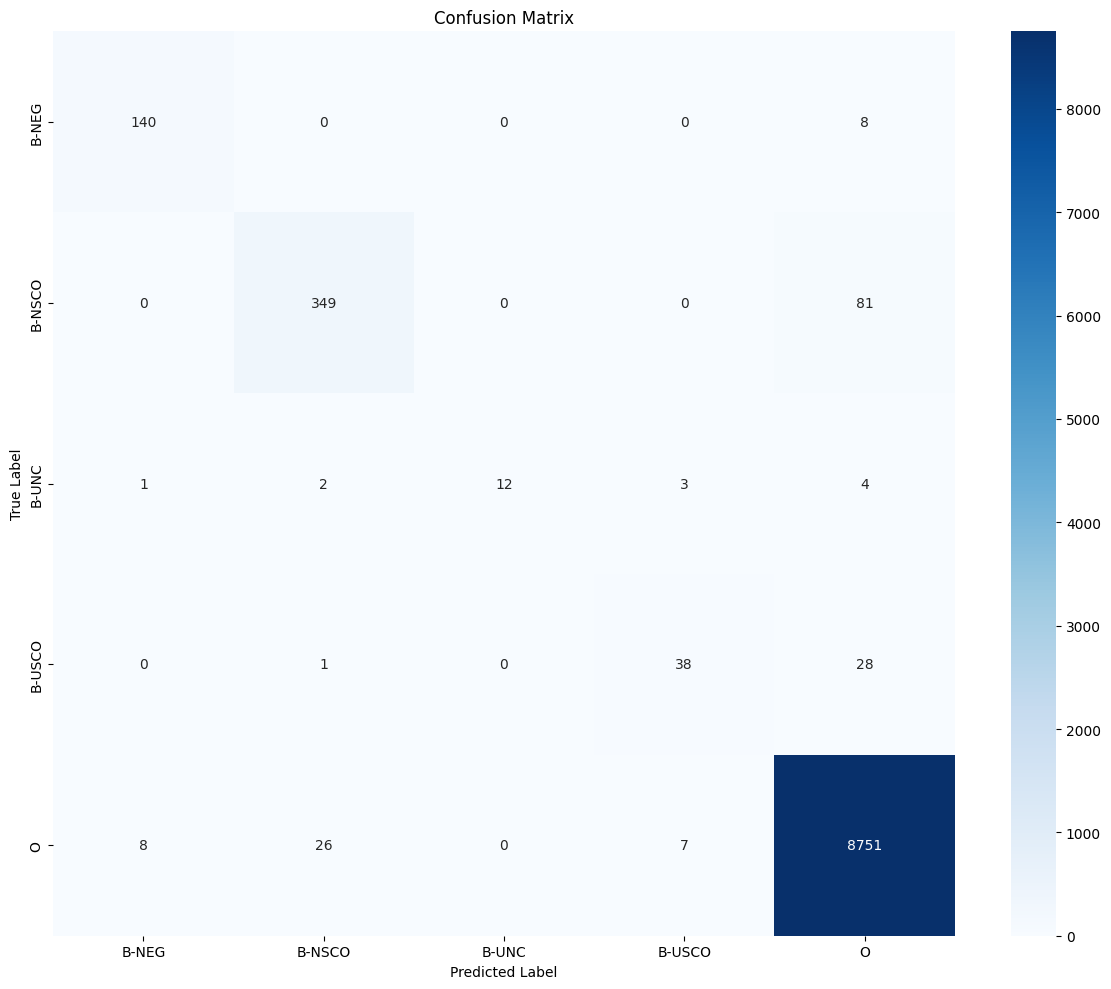

In [11]:
import json
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF, metrics
from sklearn.metrics import confusion_matrix
import pandas as pd
from collections import Counter, defaultdict
import joblib
import re

# Inicialització models spaCy
try:
    nlp_es = spacy.load("es_core_news_sm")
except OSError:
    import sys
    import subprocess
    print("Installing Spanish model...")
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "es_core_news_sm"])
    nlp_es = spacy.load("es_core_news_sm")

try:
    nlp_ca = spacy.load("ca_core_news_sm")
except OSError:
    import sys
    import subprocess
    print("Installing Catalan model...")
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "ca_core_news_sm"])
    nlp_ca = spacy.load("ca_core_news_sm")

# Cues de negació i incertesa
negation_cues = {
    "no", "sin", "ausencia de", "descarta", "descartado", "excluye", "excluido", "niega", "negado",
    "negativa", "negación", "ningún", "ninguna", "ninguno", "imposible", "inhallable", "carece de", "nunca",
    "jamás", "tampoco", "ni", "nada", "negativo", "mai", "sin evidencia de", "no se observa", "no presenta",
    "no muestra", "no evidencia", "no compatible con", "no concluyente", "no parece", "no se detecta",
    "sin signos de", "sin síntomas de", "sin indicios de", "sin hallazgos de", "sin pruebas de",
    "sin rastro de", "ausente", "no encontrado", "sin cambios", "no se aprecian", "no se ven",
    "descartando", "descartable", "no hay evidencia de", "no hay indicación de", "libre de", "exento de",
    "sin manifestaciones de", "se excluye", "queda descartado", "ninguna evidencia de", "ningún signo de",
    "sin afección", "no identificado", "negado por el paciente", "negado clínicamente", "sin enfermedad",
    "sin afectación", "no afectado", "no positivo", "resultado negativo", "resultado no reactivo",
    "resultado no positivo", "sense", "no es detecta", "no es veu", "no hi ha", "no presenta",
    "sense indicis de", "sense evidència de", "sense senyals de", "sense rastre de", "sense afectació",
    "sense afecció", "no concloent", "sense canvis", "sense resultats", "sense manifestacions de",
    "no s'observa", "no s'aprecia", "sense presència de", "no compatible amb", "no és visible",
    "sense símptomes", "no diagnosticat", "sense senyals clars", "diagnòstic negatiu", "tampoco", "nunca"
}

uncertainty_cues = {
    "posible", "quizás", "podría", "sospecha de", "considera", "probable", "aparentemente", "puede",
    "posiblemente", "parece", "se considera", "indeterminado", "probabilidad de", "no concluyente",
    "eventual", "en estudio", "pendiente de evaluación", "sugestivo de", "sugiere", "indica que",
    "se sospecha de", "podría indicar", "dudoso", "no definido", "no específico", "no determinado",
    "valor incierto", "no claro", "no seguro", "compatible con", "aparenta ser", "tendría que evaluarse",
    "a determinar", "probabilidad baja de", "probabilidad alta de", "sin certeza", "hipotético",
    "hipotéticamente", "a confirmar", "falta de certeza", "en posible relación con", "estaría asociado",
    "aparentemente relacionado con", "se intuye", "se deduce que", "en consideración", "posible",
    "probablemente", "tal vez", "aproximadamente", "probable", "possible", "potser", "podria",
    "sospita de", "es considera", "probable", "aparentment", "pot ser", "possiblement", "sembla",
    "es sospita de", "és indeterminat", "probabilitat de", "no concloent", "eventual", "en estudi",
    "pendent d'avaluació", "suggerent de", "suggerix", "indica que", "dubtós", "no definit",
    "no específic", "no determinat", "valor incert", "no clar", "no segur", "aparentment relacionat amb",
    "es dedueix que", "en consideració"
}

stopwords = {
    "el", "la", "los", "las", "lo", "un", "una", "unos", "unas", "l'", "al", "del",
    "de", "en", "a", "por", "para", "con", "sin", "sobre", "entre", "tras", "durante",
    "i", "y", "o", "u", "que", "pero", "aunque", "como", "porque", "cuando", "donde",
    "muy", "más", "menos", "también", "siempre", "ya", "aún", "todavía",
    "se", "me", "te", "nos", "os", "le", "les", "lo", "la", "les", "nosotros", "vosotros",
    ".", ",", ";", ":", "!", "?", "¿", "¡", "(", ")", "[", "]", "{", "}", "-", "_", "…", "«", "»", "'", "\"",
    "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"
}

UMLS_MEDICAL_TERMS = [
    "interna", "cistoscopia", "uretra", "cronica", "insuficiencia", "renal", "bloqueo", "auriculoventricular",
    "primer grado", "segundo grado", "hipertension", "arterial", "protesis", "cadera", "herniorrafia", "parto",
    "eutocico", "rotura", "membranas", "prematuro", "lactancia materna", "aguda", "parcial", "angiomiolipoma",
    "quistes", "renales", "fractura", "mandibular", "ictus", "infarto", "isquemico", "cerebral", "endovenosa",
    "microcirugia", "endolaringea", "sensitiva", "axonal", "multifactorial", "déficit"
]

MEDICAL_SUFFIXES = [
    "nosis", "tomia", "patia", "losis", "lisis", "iasis", "scopica", "scopia", "tocico", "itis",
    "algia", "oma", "emia", "plegia", "penia", "cele", "plasia", "ectasia", "uria"
]

def detect_medical_suffix(word):
    for suffix in MEDICAL_SUFFIXES:
        if word.endswith(suffix):
            return True
    return False

def is_medical_term(token_text):
    token_lower = token_text.lower()
    if token_lower in UMLS_MEDICAL_TERMS:
        return True
    if detect_medical_suffix(token_lower):
        return True
    return False

phrase_delimiters = {".", ",", ";", ":", "-", "–", "—"}

def has_local_double_negation(doc, idx, negation_cues, window=3):
    neg_count = 0
    # Cercar cap enrere des de idx fins a window tokens o fins a delimitador
    for i in range(idx, max(idx - window - 1, -1), -1):
        token_text = doc[i].text.lower()
        if token_text in phrase_delimiters:
            break
        if token_text in negation_cues:
            neg_count += 1
    # Cercar cap endavant des de idx+1 fins a window tokens o fins a delimitador
    for i in range(idx + 1, min(idx + window + 1, len(doc))):
        token_text = doc[i].text.lower()
        if token_text in phrase_delimiters:
            break
        if token_text in negation_cues:
            neg_count += 1
    return neg_count >= 2

def extract_features(doc):
    features = []
    for i, token in enumerate(doc):
        token_lower = token.text.lower()
        medical_flag = is_medical_term(token_lower)
        feature = {
            'text': token_lower,
            'lemma': token.lemma_,
            'pos': token.pos_,
            'is_stop': token.is_stop,
            'is_digit': token.is_digit,
            'shape': token.shape_,
            'prefix': token.text[:3] if len(token.text) >= 3 else token.text,
            'suffix': token.text[-3:] if len(token.text) >= 3 else token.text,
            'is_negation': token_lower in negation_cues or token.lemma_.lower() in negation_cues,
            'is_uncertainty': token_lower in uncertainty_cues or token.lemma_.lower() in uncertainty_cues,
            'local_double_negation': has_local_double_negation(doc, i, negation_cues, window=3),
            'is_stopword': token_lower in stopwords,
            'is_medical_term': medical_flag,
        }
        if i > 0:
            prev_token = doc[i - 1]
            prev_lower = prev_token.text.lower()
            feature.update({
                '-1:text': prev_lower,
                '-1:lemma': prev_token.lemma_,
                '-1:pos': prev_token.pos_,
                '-1:shape': prev_token.shape_,
                '-1:is_negation': prev_lower in negation_cues or prev_token.lemma_.lower() in negation_cues,
                '-1:is_uncertainty': prev_lower in uncertainty_cues or prev_token.lemma_.lower() in uncertainty_cues,
                '-1:local_double_negation': has_local_double_negation(doc, i - 1, negation_cues, window=3),
                '-1:is_stopword': prev_lower in stopwords,
                '-1:is_medical_term': is_medical_term(prev_lower),
            })
        else:
            feature['BOS'] = True
        if i < len(doc) - 1:
            next_token = doc[i + 1]
            next_lower = next_token.text.lower()
            feature.update({
                '+1:text': next_lower,
                '+1:lemma': next_token.lemma_,
                '+1:pos': next_token.pos_,
                '+1:shape': next_token.shape_,
                '+1:is_negation': next_lower in negation_cues or next_token.lemma_.lower() in negation_cues,
                '+1:is_uncertainty': next_lower in uncertainty_cues or next_token.lemma_.lower() in uncertainty_cues,
                '+1:local_double_negation': has_local_double_negation(doc, i + 1, negation_cues, window=3),
                '+1:is_stopword': next_lower in stopwords,
                '+1:is_medical_term': is_medical_term(next_lower),
            })
        else:
            feature['EOS'] = True
        features.append(feature)
    return features

def align_bio_tags(tokens, annotations):
    bio_tags = ['O'] * len(tokens)
    for ann in annotations:
        value = ann.get("value", {})
        start = value.get("start")
        end = value.get("end")
        labels = value.get("labels", [])
        label = labels[0] if labels else None
        if start is None or end is None or label is None:
            continue
        for i, token in enumerate(tokens):
            token_start, token_end = token.idx, token.idx + len(token.text)
            if token_start >= start and token_end <= end:
                if i == 0 or bio_tags[i-1] != 'I-' + label:
                    bio_tags[i] = 'B-' + label
                else:
                    bio_tags[i] = 'I-' + label
    return bio_tags

def extract_medical_terms_with_positions(doc, bio_tags):
    medical_terms = []
    current_term = []
    current_type = None
    current_start = None
    for idx, (token, tag) in enumerate(zip(doc, bio_tags)):
        if tag.startswith('B-'):
            if current_term:
                medical_terms.append({'text': ' '.join([t.text for t in current_term]),
                                      'type': current_type,
                                      'start_token': current_start,
                                      'end_token': idx - 1,
                                      'id': f"{current_start}_{idx-1}"})
            current_term = [token]
            current_type = tag[2:]
            current_start = idx
        elif tag.startswith('I-') and current_term:
            current_term.append(token)
        else:
            if current_term:
                medical_terms.append({'text': ' '.join([t.text for t in current_term]),
                                      'type': current_type,
                                      'start_token': current_start,
                                      'end_token': idx - 1,
                                      'id': f"{current_start}_{idx-1}"})
                current_term = []
                current_type = None
                current_start = None
    if current_term:
        medical_terms.append({'text': ' '.join([t.text for t in current_term]),
                              'type': current_type,
                              'start_token': current_start,
                              'end_token': len(doc) - 1,
                              'id': f"{current_start}_{len(doc)-1}"})
    return medical_terms

def merge_overlapping_scopes(scopes):
    scopes = sorted(scopes, key=lambda x: (x['type'], x['start']))
    merged = []
    for scope in scopes:
        if not merged:
            merged.append(scope)
            continue
        last = merged[-1]
        if scope['type'] == last['type'] and scope['start'] <= last['end'] + 1:
            last['end'] = max(last['end'], scope['end'])
            last['cue'] += f", {scope['cue']}"
        else:
            merged.append(scope)
    return merged

def detect_scopes_and_assign_terms_respect_sentences(doc, bio_tags, window_size=5):
    sentences = [(sent.start, sent.end - 1) for sent in doc.sents]
    def find_sentence(token_idx):
        for start, end in sentences:
            if start <= token_idx <= end:
                return start, end
        return 0, len(doc)-1
    scopes = []
    for i, token in enumerate(doc):
        token_lower = token.text.lower()
        if token_lower in negation_cues:
            sent_start, sent_end = find_sentence(i)
            start = max(sent_start, i - window_size)
            end = min(sent_end, i + window_size)
            scopes.append({'type': 'negation', 'start': start, 'end': end, 'cue': token_lower})
        elif token_lower in uncertainty_cues:
            sent_start, sent_end = find_sentence(i)
            start = max(sent_start, i - window_size)
            end = min(sent_end, i + window_size)
            scopes.append({'type': 'uncertainty', 'start': start, 'end': end, 'cue': token_lower})
    merged_scopes = merge_overlapping_scopes(scopes)
    medical_terms = extract_medical_terms_with_positions(doc, bio_tags)
    assigned_terms = []
    assigned_term_ids = set()
    for scope in merged_scopes:
        for term in medical_terms:
            if term['id'] in assigned_term_ids:
                continue
            if term['start_token'] >= scope['start'] and term['end_token'] <= scope['end']:
                assigned_terms.append({
                    'term': term['text'],
                    'type': term['type'],
                    'scope_type': scope['type'],
                    'scope_cues': scope['cue'],
                    'scope_start': scope['start'],
                    'scope_end': scope['end'],
                    'doc_index': None
                })
                assigned_term_ids.add(term['id'])
    for term in medical_terms:
        if term['id'] not in assigned_term_ids:
            assigned_terms.append({
                'term': term['text'],
                'type': term['type'],
                'scope_type': 'affirmed',
                'scope_cues': None,
                'scope_start': None,
                'scope_end': None,
                'doc_index': None
            })
    return assigned_terms

def adjust_for_double_negation(assigned_terms, all_docs, negation_cues, window=3):
    phrase_delimiters = {".", ",", ";", ":", "-", "–", "—"}

    for term_info in assigned_terms:
        doc_idx = term_info.get('doc_index')
        if doc_idx is None:
            continue
        doc = all_docs[doc_idx]
        start = term_info.get('scope_start')
        end = term_info.get('scope_end')
        if term_info['scope_type'] != 'negation' or start is None or end is None:
            continue

        def has_double_neg_in_window(idx):
            neg_count = 0
            for i in range(idx, max(idx - window - 1, -1), -1):
                if doc[i].text in phrase_delimiters:
                    break
                if doc[i].text.lower() in negation_cues:
                    neg_count += 1
            for i in range(idx + 1, min(idx + window + 1, len(doc))):
                if doc[i].text in phrase_delimiters:
                    break
                if doc[i].text.lower() in negation_cues:
                    neg_count += 1
            return neg_count >= 2

        has_double_neg = any(has_double_neg_in_window(i) for i in range(start, end + 1))
        if has_double_neg:
            term_info['scope_type'] = 'Double Negation'
            term_info['scope_cues'] += " (Double Negation detected)"

print("Loading and processing data...")
texts, labels, raw_texts, all_docs = [], [], [], []
medical_terms_counter = Counter()
negation_uncertainty_examples = []

with open(filename, 'r', encoding='utf-8') as f:
    data = json.load(f)
    for doc_idx, record in enumerate(data):
        text = record['data']['text']
        predictions = record.get('predictions', [])
        if not predictions:
            continue
        for pred in predictions:
            catalan_chars = sum(1 for c in text if c in "àèéíòóúïüç")
            spanish_chars = sum(1 for c in text if c in "áéíóúñ")
            nlp = nlp_ca if catalan_chars > spanish_chars else nlp_es

            # Process document and append early
            doc = nlp(text)
            all_docs.append(doc)  # <-- Moure aquí

            tokens = list(doc)
            features = extract_features(doc)
            bio_tags = align_bio_tags(tokens, pred['result'])

            med_terms = extract_medical_terms_with_positions(doc, bio_tags)
            for term in med_terms:
                medical_terms_counter[(term['text'], term['type'])] += 1

            assigned_terms = detect_scopes_and_assign_terms_respect_sentences(doc, bio_tags, window_size=5)

            # Assign the correct index now that doc is in all_docs
            for term_info in assigned_terms:
                term_info['doc_index'] = len(all_docs) - 1  # Últim índex

            adjust_for_double_negation(assigned_terms, all_docs, negation_cues, window=3)

            for term_info in assigned_terms:
                if term_info['scope_type'] in ['negation', 'uncertainty', 'Double Negation']:
                    negation_uncertainty_examples.append(term_info)

            texts.append(features)
            labels.append(bio_tags)
            raw_texts.append(text)

print(f"Processed {len(texts)} documents")
print(f"Found {len(medical_terms_counter)} unique medical terms")
print(f"Found {len(negation_uncertainty_examples)} instances of medical terms with negation or uncertainty")


X_train, X_test, y_train, y_test, texts_train, texts_test, docs_train, docs_test = train_test_split(
    texts, labels, raw_texts, all_docs, test_size=0.2, random_state=42)

print("Training CRF model...")
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

preds = crf.predict(X_test)
all_labels = sorted(list(set([tag for tags in y_train + y_test for tag in tags if tag != 'O'])))
all_labels = ['O'] + all_labels

print("\nCRF Model Evaluation:")
print(metrics.flat_classification_report(y_test, preds, labels=all_labels))

def flatten_lists(lists):
    return [item for sublist in lists for item in sublist]

y_test_flat = flatten_lists(y_test)
y_pred_flat = flatten_lists(preds)

unique_labels = sorted(set(y_test_flat + y_pred_flat))
if len(unique_labels) > 15:
    unique_labels = sorted([l for l in unique_labels if l != 'O'])

conf_matrix = confusion_matrix(
    [unique_labels.index(y) if y in unique_labels else -1 for y in y_test_flat],
    [unique_labels.index(y) if y in unique_labels else -1 for y in y_pred_flat],
    labels=range(len(unique_labels))
)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

joblib.dump(crf, 'medical_negation_uncertainty_crf.pkl')
print("Model saved as 'medical_negation_uncertainty_crf.pkl'")

# Filtrat i impressió amb stopwords per negació
print("\nTop medical terms with negation context (filtered):")
valid_entity_types = {'NEG', 'UNC', 'NSCO', 'USCO'}

filtered_neg_terms = []
for term, term_type in medical_terms_counter:
    if term_type in valid_entity_types:
        term_lower = term.lower()
        if term_lower not in stopwords:
            filtered_neg_terms.append((term, medical_terms_counter[(term, term_type)]))

filtered_neg_terms = sorted(filtered_neg_terms, key=lambda x: x[1], reverse=True)
for term, count in filtered_neg_terms[:10]:
    print(f"  - {term}: {count} occurrences")

# Filtrat i impressió amb stopwords per incertesa
print("\nTop medical terms with uncertainty context (filtered):")
filtered_unc_terms = []
for term, term_type in medical_terms_counter:
    if term_type in valid_entity_types:
        term_lower = term.lower()
        if term_lower not in stopwords:
            filtered_unc_terms.append((term, medical_terms_counter[(term, term_type)]))

filtered_unc_terms = sorted(filtered_unc_terms, key=lambda x: x[1], reverse=True)
for term, count in filtered_unc_terms[:10]:
    print(f"  - {term}: {count} occurrences")

# Filtrat i impressió amb stopwords per doble negació
double_neg_terms = [ex['term'] for ex in negation_uncertainty_examples if ex['scope_type'] == 'Double Negation']

double_neg_term_counter = Counter(double_neg_terms)

print("\nTop medical terms with local double negation (filtered):")
filtered_dneg_terms = []
for term, count in double_neg_term_counter.items():
    term_lower = term.lower()
    if (
        term_lower not in stopwords and
        not re.fullmatch(r'\W+', term_lower)
    ):
        filtered_dneg_terms.append((term, count))

filtered_dneg_terms = sorted(filtered_dneg_terms, key=lambda x: x[1], reverse=True)

for term, count in filtered_dneg_terms[:10]:
    print(f"  - {term}: {count} occurrences")

from collections import defaultdict

neg_terms = [ex for ex in negation_uncertainty_examples if ex['scope_type'] == 'negation']
unc_terms = [ex for ex in negation_uncertainty_examples if ex['scope_type'] == 'uncertainty']
dn_terms  = [ex for ex in negation_uncertainty_examples if ex['scope_type'] == 'Double Negation']

def group_terms_by_scope(terms_list, all_docs):
    grouped = defaultdict(lambda: {'terms': [], 'scope_cues': None, 'context_text': None})
    for term_info in terms_list:
        key = (term_info['doc_index'], term_info['scope_start'], term_info['scope_end'])
        grouped[key]['terms'].append((term_info['term'], term_info['type']))
        grouped[key]['scope_cues'] = term_info['scope_cues']
        if grouped[key]['context_text'] is None and term_info['scope_start'] is not None:
            doc_idx = term_info['doc_index']
            start, end = term_info['scope_start'], term_info['scope_end']
            grouped[key]['context_text'] = ' '.join([token.text for token in all_docs[doc_idx][start:end+1]])
    return grouped

print("\nGrouped examples of medical terms with negation:")
grouped_negation = group_terms_by_scope(neg_terms, all_docs)
for (doc_idx, start, end), info in list(grouped_negation.items())[:5]:
    print(f"Scope cues: {info['scope_cues']}")
    print(f"Context tokens: {info['context_text']}")
    print("Terms in scope:")
    for term, ttype in info['terms']:
        print(f" - {term} ({ttype})")
    print()

print("\nGrouped examples of medical terms with uncertainty:")
grouped_uncertainty = group_terms_by_scope(unc_terms, all_docs)
for (doc_idx, start, end), info in list(grouped_uncertainty.items())[:5]:
    print(f"Scope cues: {info['scope_cues']}")
    print(f"Context tokens: {info['context_text']}")
    print("Terms in scope:")
    for term, ttype in info['terms']:
        print(f" - {term} ({ttype})")
    print()

print("\nGrouped examples of medical terms with double negattion:")
grouped_d_neg = group_terms_by_scope(dn_terms, all_docs)
for (doc_idx, start, end), info in list(grouped_d_neg.items())[:5]:
    print(f"Scope cues: {info['scope_cues']}")
    print(f"Context tokens: {info['context_text']}")
    print("Terms in scope:")
    for term, ttype in info['terms']:
        print(f" - {term} ({ttype})")
    print()

print("\nAnalysis complete!")


In [ ]:
# Assegura't de tenir importada i definida la funció adjust_for_double_negation i PHRASE_SEPARATORS, get_phrase_bounds, has_local_double_negation, etc.

def process_new_text(text, crf_model, window_size=5):
    # tria model per idioma
    catalan_chars = sum(1 for c in text if c in "àèéíòóúïüç")
    spanish_chars = sum(1 for c in text if c in "áéíóúñ")
    nlp = nlp_ca if catalan_chars > spanish_chars else nlp_es

    # processa
    doc = nlp(text)
    features = extract_features(doc)
    bio_tags = crf_model.predict([features])[0]

    # treu termes i àmbits
    assigned_terms = detect_scopes_and_assign_terms_respect_sentences(doc, bio_tags, window_size=window_size)

    # Necessitem aplicar la doble negació sobre aquest document
    # Preparem un all_docs local
    local_docs = [doc]
    for term_info in assigned_terms:
        term_info['doc_index'] = 0
    adjust_for_double_negation(assigned_terms, local_docs, negation_cues, window=window_size)

    # mostrem
    print(f"\nResults for new text:\n{text}\n")
    for term_info in assigned_terms:
        mark = "✅ affirmed by double-negation" if term_info['scope_type']=="Double Negation" else ""
        print(
            f"Term: '{term_info['term']}' ({term_info['type']}) "
            f"  Scope: {term_info['scope_type']}  Cues: {term_info['scope_cues']} {mark}\n"
        )

# Exemple de prova
sample_text = "El paciente no niega que tenga síntomas de fiebre."
print("\nTesting double-negation sample:")
process_new_text(sample_text, crf)


# Test on a sample text
sample_text = "El paciente no presenta signos de infección respiratoria pero podría tener hipertensión."
print("\nTesting on Casellano sample text:")
process_new_text(sample_text, crf)


sample_text = "El pacient no presenta signes d'infecció respiratòria però podria tenir hipertensió."
print("\nTesting on Catalan sample text:")
process_new_text(sample_text, crf)

sample_text = "El paciente no niega que tenga síntomas. Ni sí, ni no."
print("\nTesting on Double Negation sample text:")
process_new_text(sample_text, crf)

In [ ]:
# Text d'exemple amb doble negació
example_text = "El paciente no niega que no tenga síntomas."

# Processar text amb SpaCy (assumim que és castellà)
doc = nlp_es(example_text)

print("Tokens i detecció local de doble negació:")
for i, token in enumerate(doc):
    doble_neg = has_local_double_negation(doc, i, negation_cues, window=3)
    print(f"Token: '{token.text}' - Local doble negació: {doble_neg}")